In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("hotels-vienna.csv")
df = df.replace("17. Hernals", "Hernals")

# Seleção de variáveis

Como o país de todas é Austria, todas cidades são Vienna, iremos descartar tais variável. Para todos os quartos, a o center1label e o center2label são city center, e Donauturm, e temos duas distâncias do quarto até esses dois locais, então vamos apagar as duas labels e distance_alter, e renomear distance_alter como "center_distance". Como é difícil prever o comportamento das ofertas, vamos desconsiderar essa variável também.

Além disso, todas as variáveis de data são idênticas para todos imóveis, pois foram orçados/coletados na mesma data. Todos imóveis foram consultados preços de apenas 1 noite também. Então também serão descartadas.

Ainda, scarce_room será desprezado, já que é difícil ter certeza da veracidade da informação, que pode ser usada para atrair interessados, e já que possui pouca relevância no nosso caso.

In [3]:
df = df.drop(["center1label", "center2label", 
              "country", "city", "distance_alter", 
              "offer_cat", "year", "month", 
              "weekend", "holiday", "nnights", 
              "offer", "scarce_room"], axis=1)

df = df.rename(columns={"distance" : "center_distance"})

df = df.set_index("hotel_id")

### Cidade

In [4]:
df = df.drop(df[df["city_actual"] != "Vienna"].index)
df = df.drop("city_actual", axis=1)

# Avaliações

Como as avaliações ratings e ratingsta tem média e std muito semelhantes, podemos considerar que ambas representam de forma semelhante os imóveis. Vamos então usar a média das duas avaliações como sendo a avaliação referência. Isso também será usado para preencher valores ausentes. Porém, não será considerada na soma, uma avaliação com menos de 5 votos. Se nenhuma das avaliações for considerada válida, será considerado que o imóvel não possui avaliações. Isso é importante para evitar imóveis muito pouco populares, ou votações enviesadas. Esses imóveis serão evitados, podendo ser removidos dos nossos dados.

In [5]:
ratings_vars = [("rating", "rating_count"), 
                ("ratingta", "ratingta_count")] 

In [6]:
import numpy as np

# Copiando coluna 
ratings_mean = df["rating"].copy()
ratings_mean[:] = 0

# Calculando média com valores válidos
for i in df.index:
    row = df.loc[i]

    # Quantidade de valores somados
    n = 0

    # Somar rating se existir e tiver 5 votos ou mais
    if not np.isnan(row["rating"]) and  row["rating_count"] >= 5:
        ratings_mean[i] += row["rating"]
        n += 1

    # Somar ratingta se existir e tiver 5 votos ou mais
    if not np.isnan(row["ratingta"]) and  row["ratingta_count"] >= 5:
        ratings_mean[i] += row["ratingta"]
        n +=1 

    # Dividir pela quantidade somada (se nenhum, atribuir NAN)
    if n != 0:
        ratings_mean[i] /= n
    else:
        ratings_mean[i] = np.nan

# Incluir coluna e remover antigas
df = df.drop(["rating", "ratingta", "rating_count", "ratingta_count"], axis=1)
df["ratings_mean"] = ratings_mean

# Remover dados com avaliações ausentes 
df = df.dropna()

In [7]:
df

,neighbourhood,price,stars,center_distance,accommodation_type,ratings_mean
hotel_id,,,,,,
21894,Hernals,81,4.0,2.7,Apartment,4.45
21897,Hernals,81,4.0,1.7,Hotel,3.70
21901,Alsergrund,85,4.0,1.4,Hotel,3.60
21902,Alsergrund,83,3.0,1.7,Hotel,4.00
21903,Alsergrund,82,4.0,1.2,Hotel,3.70
...,...,...,...,...,...,...
22404,Wieden,109,3.0,1.5,Apartment,3.00
22406,Wieden,185,5.0,0.8,Hotel,4.15
22407,Wieden,100,4.0,1.0,Hotel,4.45


# Neighbourhood "Vienna"

Constam na variável "neighbourhood", alguns imóveis marcados como "Vienna", o que causa algum estranhamento, parecendo se tratar de uma vizinhança não especificada, ou generalizada. E de fato, quando agrupamos por vizinhança, e verificamos, vemos que o desvio padrão amostral é o mais alto de todos, ou seja, característico de imóveis em diversas vizinhanças diferentes (não especificadas), generalizadas como "Vienna".

In [8]:
df.groupby("neighbourhood")["center_distance"].std().sort_values(ascending=False).head(5)

neighbourhood
Vienna        1.362813
Ottakring     1.066146
Hernals       0.707107
Schonbrunn    0.648286
Wahring       0.547723
Name: center_distance, dtype: float64

Ainda, poderíamos supor que é um nome usado para regiões muito centrais, como significasse o mesmo que centro. Mas quando analisamos as médias de distância do centro, vemos que Vienna tem uma das maiores médias. Só sobra então a possibilidade que a vizinhança Vienna significa em qualquer região de Vienna, ou não especificado.

In [9]:
df.groupby("neighbourhood")["center_distance"].mean().sort_values(ascending=False).head(5)

neighbourhood
Donaustadt              3.557143
Vienna                  3.525714
Schonbrunn              2.878571
Ottakring               2.750000
Rudolfsheim-Funfhaus    2.277778
Name: center_distance, dtype: float64

# Dados prontos, com colunas ordenadas hierarquicamente

Por último, como queremos quartos que sejam realmente em Vienna, e não em outra cidade, mesmo que próximo, removeremos quartos que não são de fato em Vienna, e excluirémos a variável city_actual.

In [10]:
df = df[["accommodation_type", "neighbourhood", "stars", "center_distance", "ratings_mean", "price"]]
df = df.sort_values(by=["accommodation_type", "neighbourhood", "stars"]) 
df

,accommodation_type,neighbourhood,stars,center_distance,ratings_mean,price
hotel_id,,,,,,
22029,Apart-hotel,Innere Stadt,4.0,0.2,4.50,116
22057,Apart-hotel,Innere Stadt,4.0,0.3,4.45,163
22086,Apart-hotel,Josefstadt,3.5,1.0,3.60,81
22337,Apart-hotel,Vienna,3.5,2.3,4.20,125
21915,Apartment,Alsergrund,2.0,1.2,3.70,143
...,...,...,...,...,...,...
22225,Pension,Mariahilf,4.0,1.1,4.05,75
22366,Pension,Vienna,2.0,2.5,3.35,92
22326,Pension,Vienna,3.0,4.7,4.40,110


# Preço x Distância do centro

Abaixo podemos ver o comportamento das amostras, de preço até 500, e distância até 3,5. Podemos ver que existem muitos quartos perto da origem, nos quais temos interesse. Posteriormente iremos buscar quais são esses quartos perto da origem.

(-0.1, 5.0)

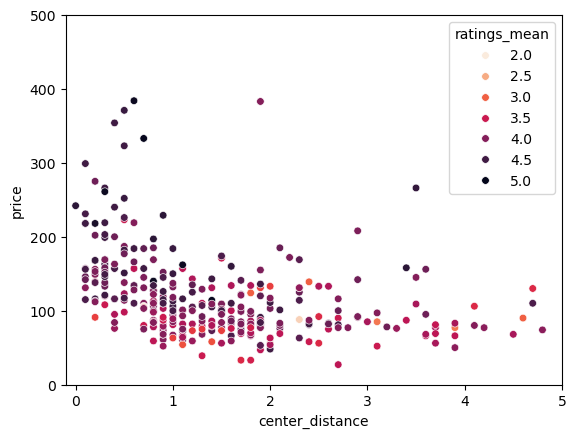

In [11]:
palette = sns.color_palette("rocket_r", as_cmap=True)
sns.scatterplot(data=df, 
                x="center_distance", 
                y="price", 
                hue="ratings_mean", 
                palette=palette,
                s=30)

plt.ylim(0,500)
plt.xlim(-0.1,5)

# Tipos de quartos

Podemos ver também as diferenças entre os tipos de quartos em relação à preço e avaliação. Vemos que eles variam mais em preço, mas muito pouco em avaliação média.

(0.0, 140.0)

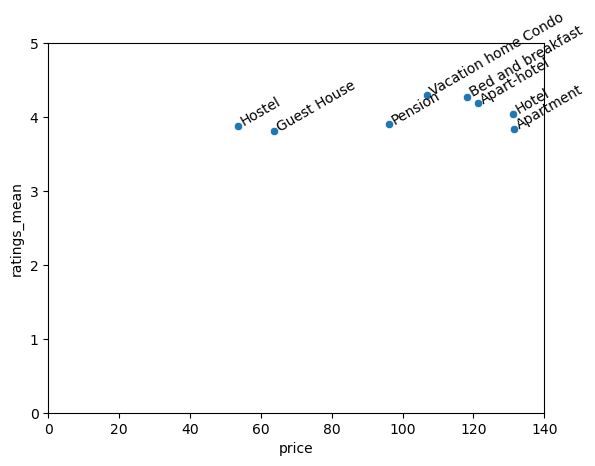

In [12]:
type_prices = df.groupby("accommodation_type")["price"].mean()
type_ratings = df.groupby("accommodation_type")["ratings_mean"].mean()
sns.scatterplot(x=type_prices, y=type_ratings)

for label, x, y in zip(type_prices.index, type_prices.values, type_ratings.values):
    plt.annotate(label, (x, y), rotation=30)

plt.ylim(0,5)
plt.xlim(0,140)

## Distribuição dos preços por tipo de quarto, até 240 euros

Podemos ver pela distribuição dos preços por tipo de quartos, que a maioria tem mediana próxima de um mesmo valor, e aparentam ser aproximadamente simétrica, tendo como exceção maior o Hostel e a Guest House. As amplitudes são o que mais variam entre eles. O apartamento e o hotel parecem interessantes para buscar por um pechincha, já que são tipos de imóveis caracterizados por um valor mais alto que podem chegar a ter quartos bem mais baratos que a mediana.

(0.0, 240.0)

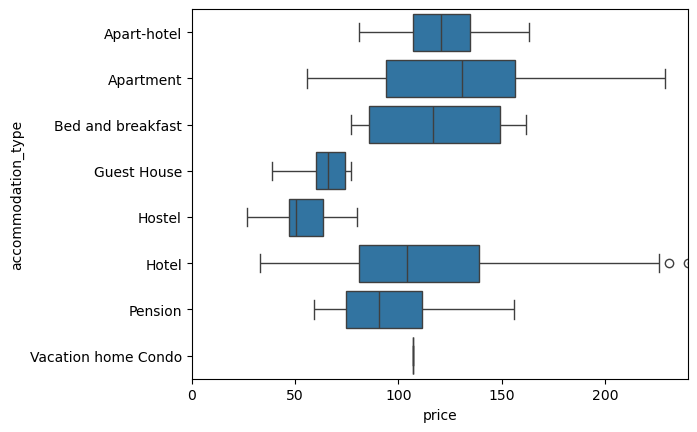

In [13]:
sns.boxplot(data=df, y="accommodation_type", x="price")
plt.xlim(0, 240)

# Quartos mais próximos da origem (bem baratos, e bem próximos do centro)

Normalizando os dados de preço e distância, e calculando norma euclidiana para achar os dados mais próximos do vértice, ou seja, os quartos que estão o mais próximo, de **idealmente** não custarem nada, e serem exatamente no centro de Vienna

In [14]:
price = df["price"]
dist = df["center_distance"]

# Calculando raio da distância 0, e preço 0
df["radius"] = (((price-price.mean())/price.std())**2 + ((dist-dist.mean())/dist.std())**2)**0.5
df["radius"] = df["radius"].round(2)

# Ordenando por raio, filtrando por rating_mean
df_best = df.sort_values(by="radius").query("ratings_mean > 4.0").head(10)
df_best

,accommodation_type,neighbourhood,stars,center_distance,ratings_mean,price,radius
hotel_id,,,,,,,
22373,Apartment,Vienna,4.0,1.4,4.95,114,0.15
22206,Hotel,Margareten,4.0,1.3,4.05,129,0.16
22123,Hotel,Landstrasse,4.0,1.5,4.05,109,0.19
22141,Apartment,Landstrasse,3.0,1.4,4.50,143,0.19
22255,Hotel,Neubau,4.0,1.7,4.15,122,0.20
22386,Hotel,Wieden,3.5,1.6,4.50,110,0.21
22395,Hotel,Wieden,4.0,1.2,4.45,125,0.24
22226,Hotel,Mariahilf,4.0,1.4,4.45,105,0.24
22156,Apartment,Leopoldstadt,5.0,1.7,4.30,141,0.25


Vamos analisar se esses resultados estão bons. Vamos comparar às médias de distâncias do centro, e as médias de preço por tipo de quarto. Podemos ver, que estes apartamentos que têm a menor norma euclidiana de distância e preço, e podemos calcula a diferença que eles possuem em relação à suas médias.

In [15]:
prices = df.groupby("accommodation_type")["price"].mean()[["Apartment", "Hotel"]]
distances = df.groupby("accommodation_type")["center_distance"].mean()[["Apartment", "Hotel"]]
types_means = pd.DataFrame([prices, distances]).round(2)
types_means

accommodation_type,Apartment,Hotel
price,131.44,131.07
center_distance,1.63,1.42


In [16]:
means_prices = df_best["price"].copy()
means_dist = df_best["price"].copy()
means_prices[:] = means_dist[:] = None

for i in df_best.index:
    means_dist.loc[i] = types_means[df_best.loc[i]["accommodation_type"]]["center_distance"]
    means_prices.loc[i] = types_means[df_best.loc[i]["accommodation_type"]]["price"]

Chegamos então à relação dos menores raios, e a relação dos preços e distâncias em relação à média.

In [17]:
df_best["center_distance"] -= means_dist
df_best["price"] -= means_prices

df_best

,accommodation_type,neighbourhood,stars,center_distance,ratings_mean,price,radius
hotel_id,,,,,,,
22373,Apartment,Vienna,4.0,-0.23,4.95,-17.44,0.15
22206,Hotel,Margareten,4.0,-0.12,4.05,-2.07,0.16
22123,Hotel,Landstrasse,4.0,0.08,4.05,-22.07,0.19
22141,Apartment,Landstrasse,3.0,-0.23,4.50,11.56,0.19
22255,Hotel,Neubau,4.0,0.28,4.15,-9.07,0.20
22386,Hotel,Wieden,3.5,0.18,4.50,-21.07,0.21
22395,Hotel,Wieden,4.0,-0.22,4.45,-6.07,0.24
22226,Hotel,Mariahilf,4.0,-0.02,4.45,-26.07,0.24
22156,Apartment,Leopoldstadt,5.0,0.07,4.30,9.56,0.25


Filtrando quartos que possuem distância do centro abaixo da média, e preço abaixo da média, elegemos as melhores pechinchas em termos de quartos para uma viagem à Vienna, na ordem definida abaixo. Por terem uma boa relação de preço e distância do centro, boas avaliações, todos sendo quartos de 4 estrelas.

In [18]:
df_best.query("center_distance < 0 and price < 0")

,accommodation_type,neighbourhood,stars,center_distance,ratings_mean,price,radius
hotel_id,,,,,,,
22373,Apartment,Vienna,4.0,-0.23,4.95,-17.44,0.15
22206,Hotel,Margareten,4.0,-0.12,4.05,-2.07,0.16
22395,Hotel,Wieden,4.0,-0.22,4.45,-6.07,0.24
22226,Hotel,Mariahilf,4.0,-0.02,4.45,-26.07,0.24
